In [1]:
import xarray as xr
import xesmf as xe
import numpy as np 
import pathlib as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

Text(0.5, 1.0, 'DEM Difference -- ASO - Orig.')

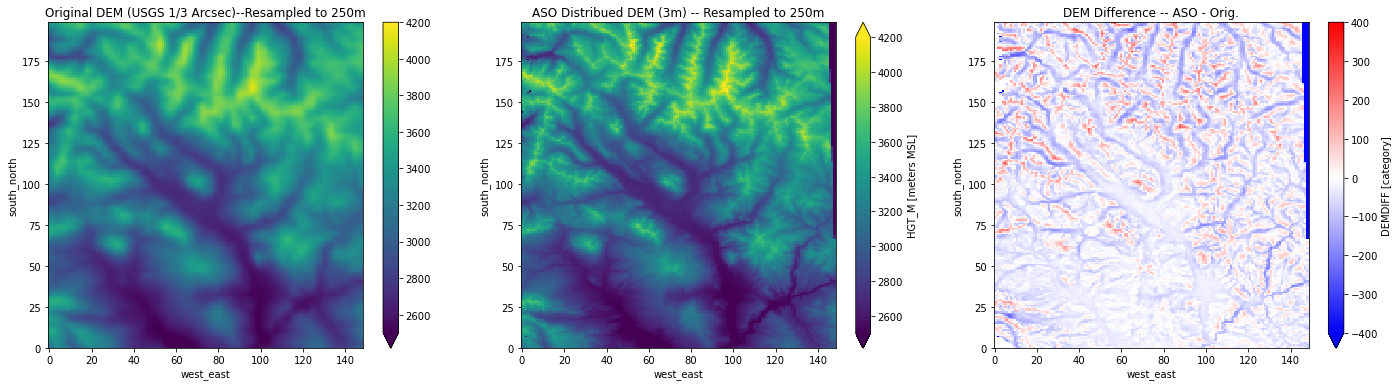

In [3]:
aspect =  xr.open_dataset("../250m_ModelRuns/ASO_aspect_regridded.nc")
slope = xr.open_dataset("../250m_ModelRuns/ASO_slope_regridded.nc")
aspect = aspect.rename(dict(__xarray_dataarray_variable__="aspect"))
slope = slope.rename(dict(__xarray_dataarray_variable__="slope"))
geom = xr.open_dataset("../250m_ModelRuns/geo_em_updatedDEM.d01.nc")

# 
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,6)


(geom.HGT_M - geom.DEMDIFF).plot(vmin=2500, vmax=4200, ax=ax[0])
geom.HGT_M.plot(vmin=2500, vmax=4200, ax=ax[1])
geom.DEMDIFF.plot(ax=ax[2], vmin=-400, vmax=400, cmap='bwr')

ax[0].set_title("Original DEM (USGS 1/3 Arcsec)--Resampled to 250m")
ax[1].set_title("ASO Distribued DEM (3m) -- Resampled to 250m")
ax[2].set_title("DEM Difference -- ASO - Orig.")

In [113]:
grid = np.zeros((30,30))

In [568]:
def sx(var, i, j):
    # alpha is the search radius...
    # dirc is the direction...
    # dist is the length to look upstream
    sample_point = var[i,j]
    dx, dy = 50,50 # 50 meter grid cells... square. 
    maxx, maxy = var.shape
    
    # make the output 
    out = np.zeros_like(var)
    
    # do some looping 
    lmax = 0
    slen = 5 # search length
    
    values_arr = np.ones(slen*(slen-1))*9999.
    
    # max dx 
    for k in range(slen):
        for l in range(-lmax,lmax):
            # out[i-l,j-k]= 1
            # do something to prevent going out of bounds here        
            if ((i-l) < 0): 
                continue
            if ((i-l) >= maxx):
                continue 
            if ((j-k) < 0):
                continue 
            # now compute the thing that winstral does 
            # get the height difference 
            rise = var[i-l, j-k] - var[i,j]
            run  = np.sqrt(((i-l)*dx)**2 + ((j-k)*dy)**2)
            values_arr[k*l] = np.arctan(rise/run)
                
            #out[i-l,j-k] = np.arctan((var[k,l] - var[i,j])/(  ((k-i)*dx)**2 + ((l-j)*dy)**2  ) **.5 )
            #out[i-l,j-k]= np.arctan((var[k,l] - var[i,j])/(  ((k-i)*dx)**2 + ((l-j)*dy)**2  ) **.5 )
        lmax += 1
    
    # get ... the value
    mv = values_arr[~(values_arr == 9999)]
    if len(mv) > 0:
        return np.max(mv)
    else:
        0.
        
    # now define the range of upstream points to look at
    
    

In [570]:
grid = geom.HGT_M.isel().values[0,::-1,:]
grid.shape


(199, 149)

In [571]:
newgrid = np.zeros_like(grid)
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        newgrid[i,j] = sx(grid, i,j)


<ipython-input-568-0f58a6c969b9>:33: RuntimeWarning: divide by zero encountered in true_divide
  values_arr[k*l] = np.arctan(rise/run)


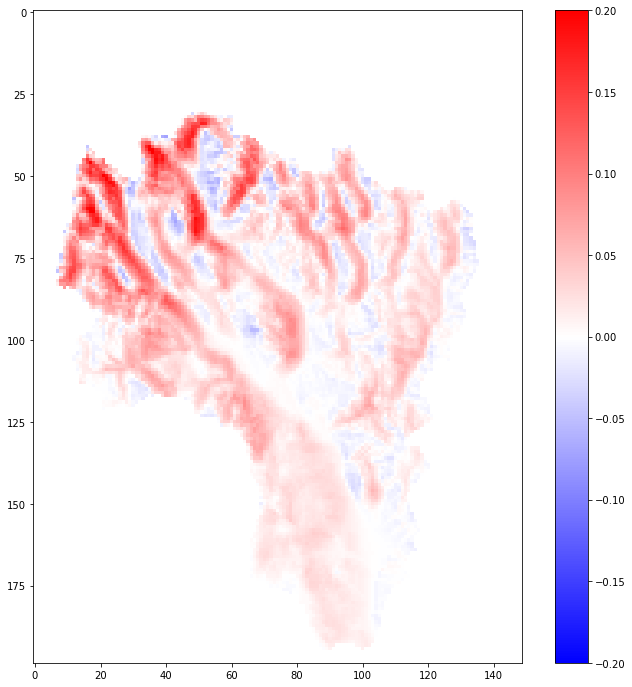

In [572]:
em = geom.EAST_MASK.isel(Time=0).values[::-1,:]
em = np.where(em > 0, em, np.nan)


fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12)
cb=ax.imshow(newgrid*em, cmap='bwr', vmin=-.2, vmax=.2)
fig.colorbar(cb)

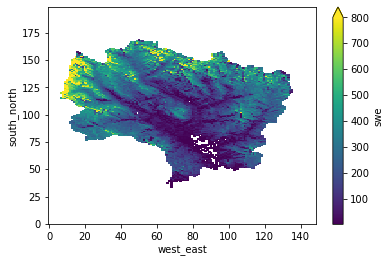

In [573]:
aso_dat1 = pl.Path("../250m_ModelRuns/regrid250m_ASO_50M_SWE_USCOGE_20180331_clipped_nobuffer_latlon.nc")
swe1=xr.open_dataset(aso_dat1)
# swe = swe.rename({'__xarray_dataarray_variable__':'swe', 'lon': 'longitude', 'lat': 'latitude'})
# swe = swe.drop(['time', 'band'])
swevar1 = swe1.where(swe1>0).swe*1000
mask = swevar1/swevar1
swevar1.plot(vmax=800)

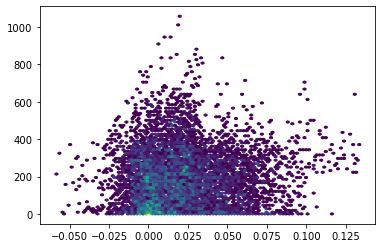

In [582]:
plt.hexbin((newgrid*em).flatten(), swevar1.values.flatten(), mincnt=1)

In [543]:
for i,j in np.argwhere(grid < 2600):
    grid[i,j] = np.mean(grid[i-1:i+1, j-1:j+1])

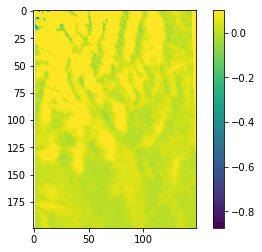

In [522]:
plt.imshow(newgrid, vmax=.1)
plt.colorbar()

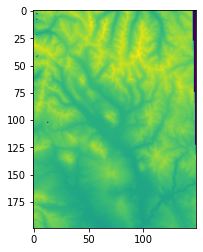

In [516]:
plt.imshow(grid)

In [ ]:
# # define normalized 2D gaussian
# def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
#     return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

# x = np.linspace(-25, 25)
# y = np.linspace(-25, 25)
# x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
# grid = gaus2d(x, y, sx=5, sy=5) * 1e5
# plt.imshow(grid)
# plt.colorbar()